In [54]:
import librosa
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.signal as signal
from tabulate import tabulate

In [55]:
# Global parameters used in preprocessing

PREFIXES = ["voiced/voiced_", "silent/silent_"]
FILENAMES = ["angry", "excited", "happy", "sad", "surprised"]
NUM_CHANNELS = 3
UNWANTED_CHANNELS = []

NFFT = 128
SAMPLE_RATE = 1152
LOW_CUTOFF = 10
HIGH_CUTOFF = 450

In [56]:
# Open the .txt containing the sensor output
# and then store the values for plotting
raw_data = []

for file_id, filename in enumerate(FILENAMES):
  a = []
  for prefix_id, prefix in enumerate(PREFIXES):
    # print(f"{prefix}{filename}.txt")
    with open(f"{prefix}{filename}.txt", "r") as f:
      temp = f.read().splitlines()
      num_points = len(temp)
      temp_data = np.zeros((NUM_CHANNELS, num_points))
      for c, t in enumerate(temp):
        split = t.split(',')
        for i in range(NUM_CHANNELS):
          temp_data[i][c] = split[i]
      a.append((len(temp_data), temp_data))
  
  max_points = max(i[0] for i in a)
  for data in a:
    np.resize(data[1], (NUM_CHANNELS, max_points))
  raw_data.append([i[1] for i in a])

####################################
# The shape of the data format is 3 dimensional:
#   1st dimension: emotion
#   2nd dimension: modality (voiced/silent)
#   3rd dimension: sEMG channels
####################################

In [57]:
print(f"There are {len(raw_data)} entries that are being compared between {len(PREFIXES)} modalities:")

table = []
for i in range(len(raw_data)):
    table.append([FILENAMES[i], len(raw_data[i][0][0]), len(raw_data[i][1][0])])

print(tabulate(table, headers=["Emotion", "Voiced data points", "Silent data points"]))

There are 5 entries that are being compared between 2 modalities:
Emotion      Voiced data points    Silent data points
---------  --------------------  --------------------
angry                     16160                 17801
excited                   14321                 13260
happy                     17041                 15672
sad                       15812                 19837
surprised                 13188                 14624


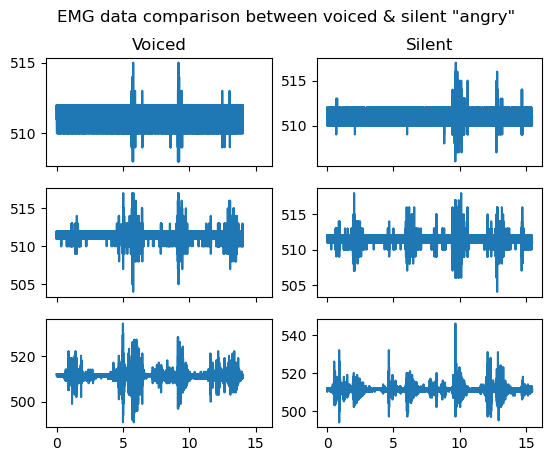

In [58]:
plot_data = raw_data[0]

fig, axs = plt.subplots(len(plot_data[0]), 2, sharex=True)
fig.suptitle('EMG data comparison between voiced & silent "angry"')

time_axes = [np.linspace(0, len(plot_data[i][0]) / SAMPLE_RATE, len(plot_data[i][0])) for i in range(len(plot_data))]

for c, i in enumerate(plot_data):
  for d, j in enumerate(i):
    axs[d, c].plot(time_axes[c], j)

axs[0, 0].set_title("Voiced")
axs[0, 1].set_title("Silent")
plt.show()

## Normalizing data

In [59]:
# For every emotion
for i in raw_data:
  # For every modality
  for j in i:
    # For every channel
    for index, k in enumerate(j):
      # as you want your data to be between -1 and 1, everything should be scaled to 2, 
      # if your desired min and max are other values, replace 2 with your_max - your_min
      ratio = 2 / (np.max(k) - np.min(k)) 
      shift = (np.max(k) + np.min(k)) / 2
      # now you need to shift the center to the middle, this is not the average of the values.
      j[index] = (k - shift) * ratio 

## Defining lowpass and highpass filters

In [60]:
def highpass_filter(data, cutoff, fs, order=5):
    # nyq = 0.5 * fs
    # normal_cutoff = cutoff / nyq
    # print(normal_cutoff)
    b, a = signal.butter(order, cutoff, fs=SAMPLE_RATE, btype='highpass', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

def lowpass_filter(data, cutoff, fs, order=5):
    # nyq = 0.5 * fs
    # normal_cutoff = cutoff / nyq
    # print(normal_cutoff)
    b, a = signal.butter(order, cutoff, fs=SAMPLE_RATE, btype='lowpass', analog=False)
    y = signal.filtfilt(b, a, data)
    return y


## Applying filters

In [61]:
# For every emotion
for i in raw_data:
  # For every modality
  for j in i:
    # For every channel
    for index, k in enumerate(j):
      temp = highpass_filter(k, LOW_CUTOFF, SAMPLE_RATE)
      j[index] = lowpass_filter(temp, HIGH_CUTOFF, SAMPLE_RATE)

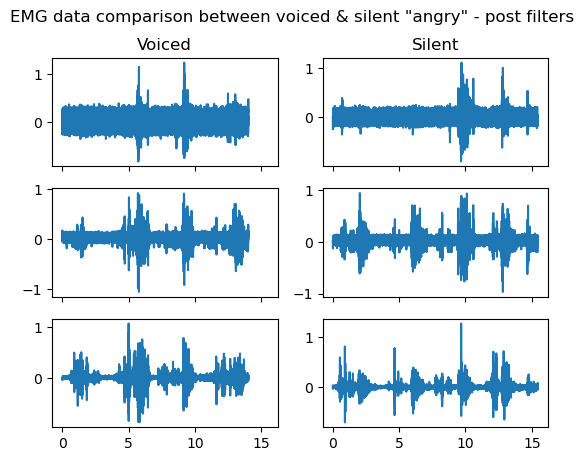

In [62]:
plot_data = raw_data[0]

fig, axs = plt.subplots(len(plot_data[0]), 2, sharex=True)
fig.suptitle('EMG data comparison between voiced & silent "angry" - post filters')

time_axes = [np.linspace(0, len(plot_data[i][0]) / SAMPLE_RATE, len(plot_data[i][0])) for i in range(len(plot_data))]

for c, i in enumerate(plot_data):
  for d, j in enumerate(i):
    axs[d, c].plot(time_axes[c], j)

axs[0, 0].set_title("Voiced")
axs[0, 1].set_title("Silent")
plt.show()

## Performing STFT

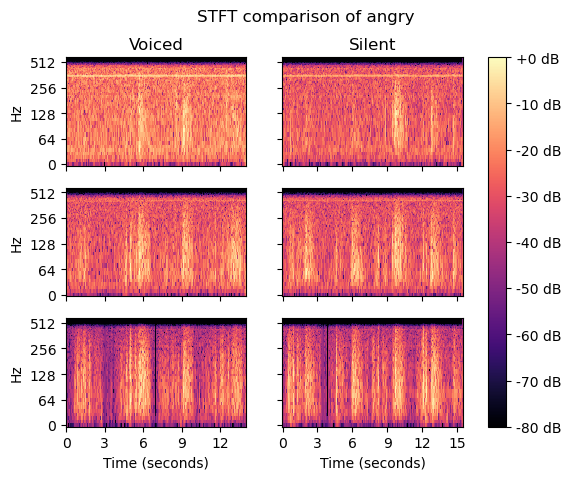

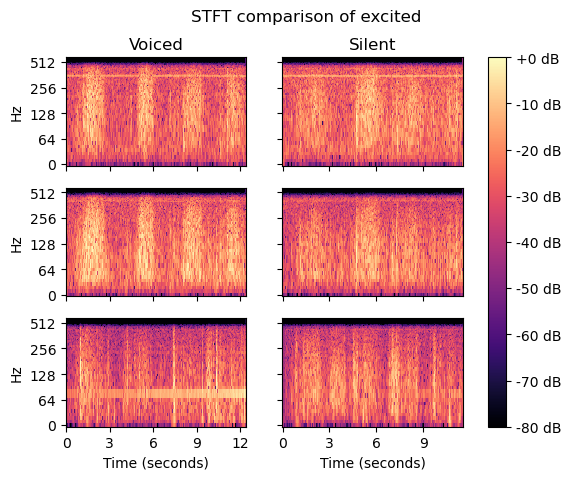

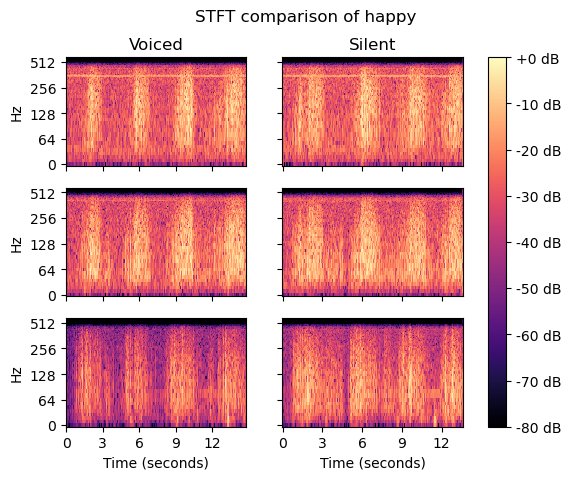

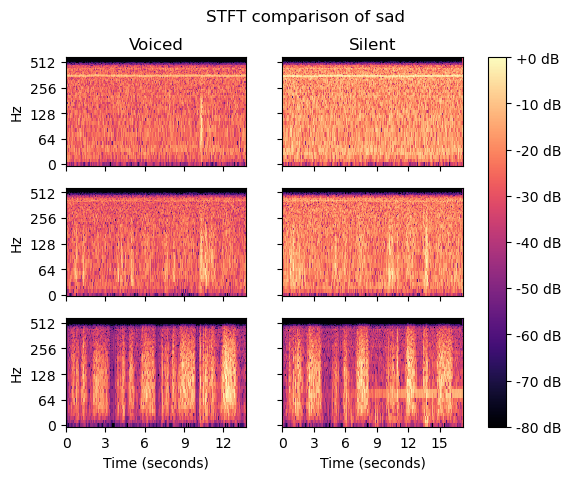

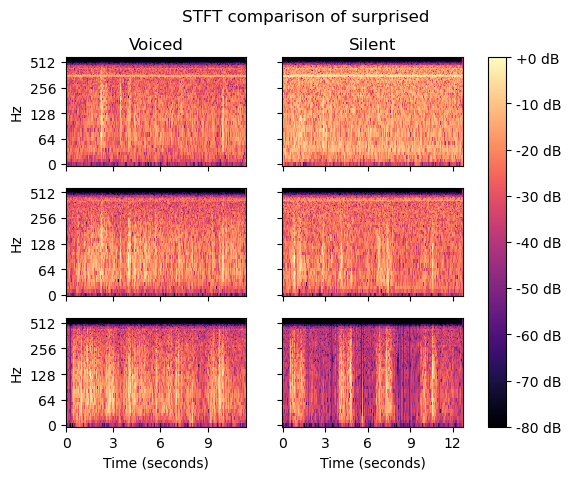

In [65]:
stft_channels = []
# For every emotion
for i in raw_data:
  emotion_stft = []
  # For every modality
  for j in i:
    emotion_stft.append(librosa.stft(j, n_fft=NFFT))
  stft_channels.append(emotion_stft)

for emotion_num, i in enumerate(stft_channels):
  fig, axs = plt.subplots(NUM_CHANNELS, 2, sharex='col', sharey=True)
  fig.suptitle(f"STFT comparison of {FILENAMES[emotion_num]}")
  for col, j in enumerate(i):
    for row, k in enumerate(j):
      img = librosa.display.specshow(librosa.amplitude_to_db
                                    (
                                    np.abs(k), ref=np.max
                                    ),
                                    y_axis='log', x_axis='s', ax=axs[row, col], sr=SAMPLE_RATE,
                                    n_fft=NFFT, hop_length=NFFT/4)
      
  fig.colorbar(img, ax=axs.ravel().tolist(), format="%+2.0f dB")
  axs[0, 0].set_title("Voiced")
  axs[0, 1].set_title("Silent")
  for ax in axs.flat:
    ax.label_outer()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

plt.show()